## Классификация новостей [AG's News Topic Classification Dataset](https://github.com/mhjabreel/CharCnn_Keras/tree/master/data/ag_news_csv)

Используется три архитектуры нейронных сетей:
- Полносвязная нейронная сеть - NN
- Одномерная сверточная нейросеть - CNN
- Рекуррентная нейронная сеть - LSTM

In [0]:
# Для отсутствия лишних предупреждений.
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy  as np

# Для визуализации гистограммы распределения кол-ва слов в описаниях книг.
from matplotlib import pyplot as plt

# Для логирования.
from tqdm import tqdm

# Для лемматизации и нормализации текстов.
!pip install pymorphy2 
!pip install nltk
import re
import nltk
import pymorphy2
from   nltk.corpus import stopwords
nltk.download('stopwords')

# Для получений эмбедингов текстов посредством мешков слов - для KNN.
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Для корректной валидации.
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer

# Для подсчёта метрики качества регрессии.
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error

# Для подсчёта метрики качества классификации.
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef

# Для подбора лучших параметров модели.
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, Flatten
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [0]:
# Максимальное количество слов 
num_words = 10000
# Максимальная длина новости
max_news_len = 30
# Количество классов новостей
nb_classes = 4

## Загрузка набора данных

Загружаем данные для обучения

In [0]:
!wget https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/train.csv -O train.csv

--2020-06-05 17:58:23--  https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/train.csv
Resolving github.com (github.com)... 13.250.177.223
Connecting to github.com (github.com)|13.250.177.223|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv [following]
--2020-06-05 17:58:23--  https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29470338 (28M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  28.10M  --.-KB/s    in 0.1s    

2020-06-05 17:58:26 (246 MB/s) - ‘train.csv’ saved [29470338/29470338]



Загружаем данные для тестирования

In [0]:
!wget https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/test.csv -O test.csv

--2020-06-05 17:58:29--  https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/test.csv
Resolving github.com (github.com)... 52.74.223.119
Connecting to github.com (github.com)|52.74.223.119|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv [following]
--2020-06-05 17:58:30--  https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1857427 (1.8M) [text/plain]
Saving to: ‘test.csv’

test.csv            100%[===================>]   1.77M  --.-KB/s    in 0.03s   

2020-06-05 17:58:32 (57.3 MB/s) - ‘test.csv’ saved [1857427/1857427]



Загружаем имена классов

In [0]:
!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/classes.txt -O classes.txt

--2020-06-05 17:58:37--  https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31 [text/plain]
Saving to: ‘classes.txt’

classes.txt         100%[===================>]      31  --.-KB/s    in 0s      

2020-06-05 17:58:38 (2.37 MB/s) - ‘classes.txt’ saved [31/31]



## Просматриваем данные

In [0]:
!ls

classes.txt  sample_data  test.csv  train.csv


In [0]:
!cat classes.txt

World
Sports
Business
Sci/Tech


In [0]:
!head train.csv

"3","Wall St. Bears Claw Back Into the Black (Reuters)","Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again."
"3","Carlyle Looks Toward Commercial Aerospace (Reuters)","Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market."
"3","Oil and Economy Cloud Stocks' Outlook (Reuters)","Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums."
"3","Iraq Halts Oil Exports from Main Southern Pipeline (Reuters)","Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday."
"3","Oil prices soar to all-time record, posing new menace to US e

In [0]:
!head test.csv

"3","Fears for T N pension after talks","Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."
"4","The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com)","SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date for its manned rocket."
"4","Ky. Company Wins Grant to Study Peptides (AP)","AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins."
"4","Prediction Unit Helps Forecast Wildfires (AP)","AP - It's barely dawn when Mike Fitzpatrick starts his shift with a blur of colorful maps, figures and endless charts, but already he knows what the day will bring. Lightning wil

In [0]:
!wc -l train.csv
!wc -l test.csv

120000 train.csv
7600 test.csv


## Загружаем данные в память

Читаем данные из файла

In [0]:
train = pd.read_csv('train.csv', 
                    header=None, 
                    names=['class', 'title', 'text'])

In [0]:
test = pd.read_csv('test.csv', 
                    header=None, 
                    names=['class', 'title', 'text'])

In [0]:
#Скрипт для Лематизации путем регульярного выражения.

stop_words = stopwords.words("english") + stopwords.words("russian")
TOKEN_RE = re.compile(r'[\w^d]+')

morph = pymorphy2.MorphAnalyzer()
min_token_size = 2

def tokenize_text(txt, min_token_size=min_token_size):
  txt = txt.lower()
  all_tokens = TOKEN_RE.findall(txt)
  return [morph.parse(token)[0].normal_form 
          for token in all_tokens 
          if len(token) >= min_token_size 
            and token not in stop_words]

In [0]:
%%time
train['tokenized_text'] = train.text.apply(lambda x: tokenize_text(x)).apply(lambda x: ' '.join(x))
test['tokenized_text']  = test.text.apply(lambda x:  tokenize_text(x)).apply(lambda x: ' '.join(x))

CPU times: user 1min 4s, sys: 184 ms, total: 1min 4s
Wall time: 1min 4s


##*k ближайших соседей* **KNN predict**

In [0]:
#%%time
vectorizer = TfidfVectorizer(tokenizer=tokenize_text,
                             max_df=0.8,
                             min_df=2,
                             ngram_range=(1,1))

vectorizer.fit(train['tokenized_text'].to_list()+test['tokenized_text'].to_list())
X_vectorized = vectorizer.transform(train['tokenized_text'].to_list())
X_vect_test  = vectorizer.transform(test['tokenized_text'].to_list())
print(X_vectorized.shape)
print(X_vect_test.shape)

(120000, 39788)
(7600, 39788)


In [0]:
y = train['class'].to_numpy()
y_test_ = test['class'].to_numpy()

In [0]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()

In [0]:
%%time
model.fit(X_vectorized, y)
y_pred = model.predict(X_vect_test)

CPU times: user 18.7 s, sys: 86.8 ms, total: 18.8 s
Wall time: 18.8 s


In [0]:
f1_scr  = f1_score(y_pred, y_test_, average='macro')
acc_scr = accuracy_score(y_pred, y_test_)
crr_scr = matthews_corrcoef(y_pred, y_test_)

print('F1:   %.3f' % f1_scr)
print('ACC:  %.3f' % acc_scr)
print('CORR: %.3f' % crr_scr)

F1:   0.894
ACC:  0.894
CORR: 0.859


##Выделяем данные для обучения

In [0]:
news = train['tokenized_text']

In [0]:
news[:5]

0    reuters short sellers wall street dwindling ba...
1    reuters private investment firm carlyle group ...
2    reuters soaring crude prices plus worries econ...
3    reuters authorities halted oil export flows ma...
4    afp tearaway world oil prices toppling records...
Name: tokenizer_text, dtype: object

Выделяем правильные ответы

In [0]:
y_train = utils.to_categorical(train['class'] - 1, nb_classes)
y_test  = utils.to_categorical(test['class'] - 1, nb_classes)

In [0]:
y_train

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

## Токенизация текста

In [0]:
news[:5]

0    reuters short sellers wall street dwindling ba...
1    reuters private investment firm carlyle group ...
2    reuters soaring crude prices plus worries econ...
3    reuters authorities halted oil export flows ma...
4    afp tearaway world oil prices toppling records...
Name: tokenizer_text, dtype: object

Создаем токенизатор Keras

In [0]:
tokenizer = Tokenizer(num_words=num_words)

Обучаем токенизатор на новостях

In [0]:
tokenizer.fit_on_texts(news)

Просматриваем словарь токенизатора

In [0]:
tokenizer.word_index

{'39': 1,
 'said': 2,
 'new': 3,
 'reuters': 4,
 'two': 5,
 'us': 6,
 'quot': 7,
 'year': 8,
 'first': 9,
 'ap': 10,
 'gt': 11,
 'lt': 12,
 'monday': 13,
 'wednesday': 14,
 'tuesday': 15,
 'one': 16,
 'world': 17,
 'company': 18,
 'thursday': 19,
 'inc': 20,
 'friday': 21,
 'last': 22,
 'yesterday': 23,
 'york': 24,
 'three': 25,
 'president': 26,
 'week': 27,
 'million': 28,
 'corp': 29,
 'oil': 30,
 'sunday': 31,
 'time': 32,
 'would': 33,
 'united': 34,
 'game': 35,
 'government': 36,
 'today': 37,
 'people': 38,
 'years': 39,
 'could': 40,
 'group': 41,
 'second': 42,
 'iraq': 43,
 'com': 44,
 'percent': 45,
 'saturday': 46,
 'software': 47,
 'night': 48,
 'next': 49,
 'third': 50,
 'season': 51,
 'prices': 52,
 'day': 53,
 'security': 54,
 'fullquote': 55,
 'microsoft': 56,
 'quarter': 57,
 'team': 58,
 'stocks': 59,
 'internet': 60,
 'minister': 61,
 'announced': 62,
 'state': 63,
 'four': 64,
 'back': 65,
 'international': 66,
 'washington': 67,
 'high': 68,
 '2004': 69,
 'may':

Преобразуем новости в числовое представление

In [0]:
train_sequences = tokenizer.texts_to_sequences(train['tokenized_text'])
test_sequences  = tokenizer.texts_to_sequences(test['tokenized_text'])

Просматриваем новости в числовом представлении

In [0]:
index = 1
print(news[index])
print(sequences[index])

reuters private investment firm carlyle group reputation making well timed occasionally controversial plays defense industry quietly placed bets another part market
[4, 749, 643, 265, 41, 3751, 356, 338, 1176, 2644, 446, 150, 3362, 1860, 8002, 138, 225, 72]


In [0]:
tokenizer.word_index['investment']

643

Ограничиваем длину отзывов

In [0]:
X_train = pad_sequences(train_sequences, maxlen=max_news_len)
X_test  = pad_sequences(test_sequences,  maxlen=max_news_len)

In [0]:
X_train[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    4,
         648, 7600,  339,  252, 2670, 5707, 3481,  713],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    4,  749,  643,  265,   41, 3751,  356,  338, 1176, 2644,
         446,  150, 3362, 1860, 8002,  138,  225,   72],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    4, 2051,  367,   52, 1439, 1353,  292,  903,  229,
         108, 6160,  222,   72,   49,   27, 5902,  915],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    4,  604,
        4949,   30, 3386, 7736,  629, 3042,  393,   43, 1271,  476,  711,
        2437,   40,  650, 2408,   30,  204,    2,   46],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,   99,   17,   30,   52, 8585, 1640, 8003, 3287,
           3,  256, 2878,   25, 

## *Полносвязная нейронная сеть* **NN predict**

In [0]:
model_nn = Sequential()
model_nn.add(Embedding(num_words, 32, input_length=max_news_len))
model_nn.add(Flatten())
model_nn.add(Dense(4, activation='softmax'))

In [0]:
model_nn.compile(optimizer='adam', 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

In [0]:
model_nn.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 30, 32)            320000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 960)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 4)                 3844      
Total params: 323,844
Trainable params: 323,844
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_nn_save_path = 'best_model_nn.h5'
checkpoint_callback_nn = ModelCheckpoint(model_nn_save_path, 
                                         monitor='val_accuracy',
                                         save_best_only=True,
                                         verbose=1)

In [0]:
history_nn = model_nn.fit(X_train, 
                           y_train, 
                           epochs=10,
                           batch_size=128,
                           validation_split=0.2,
                           callbacks=[checkpoint_callback_nn])

Epoch 1/10
748/750 [============================>.] - ETA: 0s - loss: 0.5272 - accuracy: 0.8280
Epoch 00001: val_accuracy improved from -inf to 0.89408, saving model to best_model_nn.h5
750/750 [==============================] - 4s 6ms/step - loss: 0.5267 - accuracy: 0.8281 - val_loss: 0.3121 - val_accuracy: 0.8941
Epoch 2/10
745/750 [============================>.] - ETA: 0s - loss: 0.2492 - accuracy: 0.9180
Epoch 00002: val_accuracy did not improve from 0.89408
750/750 [==============================] - 4s 6ms/step - loss: 0.2491 - accuracy: 0.9181 - val_loss: 0.3069 - val_accuracy: 0.8928
Epoch 3/10
748/750 [============================>.] - ETA: 0s - loss: 0.1986 - accuracy: 0.9341
Epoch 00003: val_accuracy did not improve from 0.89408
750/750 [==============================] - 4s 6ms/step - loss: 0.1986 - accuracy: 0.9341 - val_loss: 0.3207 - val_accuracy: 0.8868
Epoch 4/10
748/750 [============================>.] - ETA: 0s - loss: 0.1547 - accuracy: 0.9500
Epoch 00004: val_accura

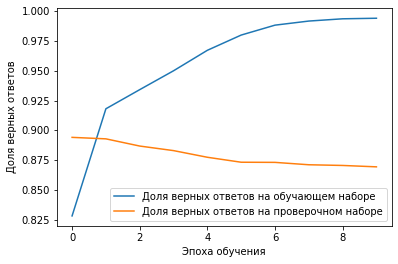

In [0]:
plt.plot(history_nn.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_nn.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [0]:
model_nn.load_weights(model_nn_save_path)

In [0]:
y_pred = model_nn.predict(X_test).argmax(1)+1

f1_scr  = f1_score(y_pred, y_test_, average='macro')
acc_scr = accuracy_score(y_pred, y_test_)
crr_scr = matthews_corrcoef(y_pred, y_test_)

print('F1:   %.3f' % f1_scr)
print('ACC:  %.3f' % acc_scr)
print('CORR: %.3f' % crr_scr)

F1:   0.896
ACC:  0.896
CORR: 0.862


## *Сверточная нейронная сеть* **CNN predict**

In [0]:
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 32, input_length=max_news_len))
model_cnn.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(4, activation='softmax'))

In [0]:
model_cnn.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [0]:
model_cnn.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 30, 32)            320000    
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 26, 250)           40250     
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 250)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 4)                 1004      
Total params: 361,254
Trainable params: 361,254
Non-trainable params: 0
_________________________________________________________________


Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`

In [0]:
model_cnn_save_path = 'best_model_cnn.h5'
checkpoint_callback_cnn = ModelCheckpoint(model_cnn_save_path, 
                                          monitor='val_accuracy',
                                          save_best_only=True,
                                          verbose=1)

In [0]:
history_cnn = model_cnn.fit(X_train, 
                            y_train, 
                            epochs=10,
                            batch_size=128,
                            validation_split=0.2,
                            callbacks=[checkpoint_callback_cnn])

Epoch 1/10
744/750 [============================>.] - ETA: 0s - loss: 0.4220 - accuracy: 0.8623
Epoch 00001: val_accuracy improved from -inf to 0.89417, saving model to best_model_cnn.h5
750/750 [==============================] - 6s 7ms/step - loss: 0.4209 - accuracy: 0.8626 - val_loss: 0.3050 - val_accuracy: 0.8942
Epoch 2/10
746/750 [============================>.] - ETA: 0s - loss: 0.2325 - accuracy: 0.9220
Epoch 00002: val_accuracy did not improve from 0.89417
750/750 [==============================] - 6s 8ms/step - loss: 0.2325 - accuracy: 0.9220 - val_loss: 0.3158 - val_accuracy: 0.8902
Epoch 3/10
750/750 [==============================] - ETA: 0s - loss: 0.1845 - accuracy: 0.9369
Epoch 00003: val_accuracy did not improve from 0.89417
750/750 [==============================] - 6s 8ms/step - loss: 0.1845 - accuracy: 0.9369 - val_loss: 0.3477 - val_accuracy: 0.8833
Epoch 4/10
749/750 [============================>.] - ETA: 0s - loss: 0.1426 - accuracy: 0.9522
Epoch 00004: val_accur

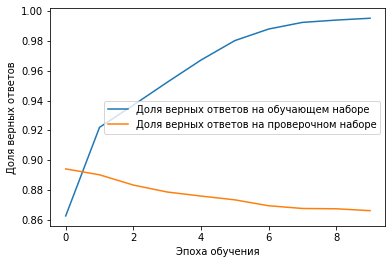

In [0]:
plt.plot(history_cnn.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [0]:
model_cnn.load_weights(model_cnn_save_path)

In [0]:
y_pred = model_cnn.predict(X_test).argmax(1)+1

f1_scr  = f1_score(y_pred, y_test_, average='macro')
acc_scr = accuracy_score(y_pred, y_test_)
crr_scr = matthews_corrcoef(y_pred, y_test_)

print('F1:   %.3f' % f1_scr)
print('ACC:  %.3f' % acc_scr)
print('CORR: %.3f' % crr_scr)

F1:   0.899
ACC:  0.899
CORR: 0.866


## *Рекурентная нейронная сеть* **LSTM predict**

In [0]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 32, input_length=max_news_len))
model_lstm.add(LSTM(8))
model_lstm.add(Dense(4, activation='softmax'))

In [0]:
model_lstm.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [0]:
model_lstm.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, 30, 32)            320000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 8)                 1312      
_________________________________________________________________
dense_54 (Dense)             (None, 4)                 36        
Total params: 321,348
Trainable params: 321,348
Non-trainable params: 0
_________________________________________________________________


Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`

In [0]:
model_lstm_save_path = 'best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [0]:
history_lstm = model_lstm.fit(X_train, 
                              y_train, 
                              epochs=10,
                              batch_size=128,
                              validation_split=0.2,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/10
744/750 [============================>.] - ETA: 0s - loss: 0.5275 - accuracy: 0.8320
Epoch 00001: val_accuracy improved from -inf to 0.88842, saving model to best_model_lstm.h5
750/750 [==============================] - 6s 8ms/step - loss: 0.5256 - accuracy: 0.8327 - val_loss: 0.3344 - val_accuracy: 0.8884
Epoch 2/10
750/750 [==============================] - ETA: 0s - loss: 0.2593 - accuracy: 0.9191
Epoch 00002: val_accuracy improved from 0.88842 to 0.88987, saving model to best_model_lstm.h5
750/750 [==============================] - 6s 8ms/step - loss: 0.2593 - accuracy: 0.9191 - val_loss: 0.3244 - val_accuracy: 0.8899
Epoch 3/10
749/750 [============================>.] - ETA: 0s - loss: 0.2143 - accuracy: 0.9323
Epoch 00003: val_accuracy did not improve from 0.88987
750/750 [==============================] - 6s 8ms/step - loss: 0.2144 - accuracy: 0.9323 - val_loss: 0.3363 - val_accuracy: 0.8865
Epoch 4/10
747/750 [============================>.] - ETA: 0s - loss: 0.1862 

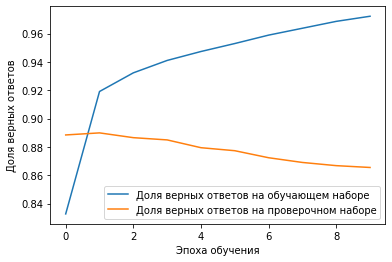

In [0]:
plt.plot(history_lstm.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [0]:
model_lstm.load_weights(model_lstm_save_path)

In [0]:
y_pred = model_lstm.predict(X_test).argmax(1)+1

f1_scr  = f1_score(y_pred, y_test_, average='macro')
acc_scr = accuracy_score(y_pred, y_test_)
crr_scr = matthews_corrcoef(y_pred, y_test_)

print('F1:   %.3f' % f1_scr)
print('ACC:  %.3f' % acc_scr)
print('CORR: %.3f' % crr_scr)

F1:   0.897
ACC:  0.897
CORR: 0.863


**Заключение экспериметов**
*Как видим, результаты всех архитектур превосходят результаты классической модели такой как KNN. Преимущество хоть и не значительно, но объясняется довольно более быстрой эксплуатацией (не нужно запоминать все 120000 объектов) и довольно примитивным наборов параметров (всего 8 циклов для LSTM и 1 слоем для CNN).*

**KNN:**
*  F1:   0.894
*  ACC:  0.894
*  CORR: 0.859

**NN:**
*  F1:   0.896
*  ACC:  0.896
*  CORR: 0.862

**CNN:**
*  F1:   0.899
*  ACC:  0.899
*  CORR: 0.866

**RNN:**
*  F1:   0.897
*  ACC:  0.897
*  CORR: 0.863